<a href="https://colab.research.google.com/github/athenianravenclaw/ASR-Basics/blob/main/EDA_%2B_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##HarperValleyBank Data Exploration & CTC Implementation


In [ ]:



import os
from google.colab import drive
drive.mount('/content/gdrive')

#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs224s_spring2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/cs224s_spring2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

Mounted at /content/gdrive


In [ ]:
#@title Download HarperValleyBank dataset
#@markdown It takes ~10 minutes to download the dataset. You only need to do this once!

DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harpervalleybank')):
  !wget -q http://web.stanford.edu/class/cs224s/download/harpervalleybank.zip
  !unzip -q harpervalleybank.zip
  %rm harpervalleybank.zip

mkdir: cannot create directory ‘/content/cs224s_spring2022/data’: Transport endpoint is not connected
[Errno 107] Transport endpoint is not connected: '/content/cs224s_spring2022/data'
/content
unzip:  cannot find or open harpervalleybank.zip, harpervalleybank.zip.zip or harpervalleybank.zip.ZIP.
rm: cannot remove 'harpervalleybank.zip': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
#@title Import packages
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import json
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from typing import Tuple
import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Part 1:  HarperValleyBank Dataset Exploration

Let's first explore the [HarperValleyBank](https://arxiv.org/abs/2010.13929) dataset! The dataset primarily consists of simulated telephone/app-based consumer to banker interactions. For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system.






## Getting Corpus Statistics

For any new dataset, it is generally a good idea to explore the "shape" and "properties" of the data. This will help greatly when debugging unexpected behavior in your speech system.

The structure of the HarperValleyBank dataset is:
```
data
    audio
        agent
            <sid1>.wav
            <sid2>.wav
            ...
        caller
            <sid1>.wav
            <sid2>.wav
            ...
    metadata
        <sid1>.json
        <sid2>.json
        ...
    transcript
        <sid1>.json
        <sid2>.json
        ...
```
Every consumer-banker conversation has an id referred to as it' `sid ` .  All associated files are named based on that sid.
Each conversation has four associated files, two audio files, one transcript file and one metadata file.
The audio for each conversation is divided in to two single channel wav files, available under the audio/agent and audio/caller directories.

##### <ins>**Task 1.1.1**</ins>: **Number of conversations** **(2 points)**

Please fill out the function `number_of_conversations` to get the number of conversations in the dataset. (This part could be done with 1 line of code)


In [ ]:
agent_audio_path = '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/audio/agent'
caller_audio_path = '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/audio/caller'
transcript_path = '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/transcript'
metadata_path = '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/metadata'

def number_of_conversations(path: str) -> int:
  """Gets number of conversations in the dataset.

  Args:
    path: Path to relevant directory.

  Returns:
    Number of conversations.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  count = 0
  directory_path=path
  for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isfile(item_path):
            count += 1
  return count
  #############################

path = transcript_path
print('Number of conversations: ' + str(number_of_conversations(path)))

Number of conversations: 1446


[link text](https://)##### <ins>**Task 1.1</ins>: Plot call duration (3 points)**

Please fill out the function `recording_time` to get the durations and total duration of recording in seconds and plot a histogram with duration of recording (in seconds) as x-axis and count of conversations as y-axis. You can use `wavfile.read()` method to read files.

For a single conversation, there are two audio files: `caller` and `agent` audio files. Both audio files for the same conversation have the same duration of recording because the other person's voice is replaced with silence. Thus, please choose either caller or agent directory to get the total duration or recording.


In [ ]:
def recording_time(path_dir: str) -> Tuple[float, np.ndarray]:
  """Gets duration of recording
  Args:
    path_dir: Path to relevant directory.

  Returns:
    Duration of total recording in seconds (float),
    Numpy array of duration of recording for all conversations

  """

  #############################
  #### YOUR CODE GOES HERE ####
  durations=[]
  total_duration=0
  for item in os.listdir(path_dir):
        item_path = os.path.join(path_dir, item)
        if os.path.isfile(item_path):
          sample_rate, aud = wavfile.read(item_path)
          duration = len(aud)/sample_rate
          total_duration+= duration
          durations.append(duration)
  return total_duration, np.array(durations)



  #############################

path_agent = agent_audio_path
path_caller = caller_audio_path
print("Duration of recordings in seconds " + str(recording_time(path_agent)[0]))

# Plot histogram: X - Duration of recording of individual file, Y - Count of audio files
#############################
#### YOUR CODE GOES HERE ####


#############################

Duration of recordings in seconds 84132.9500000001


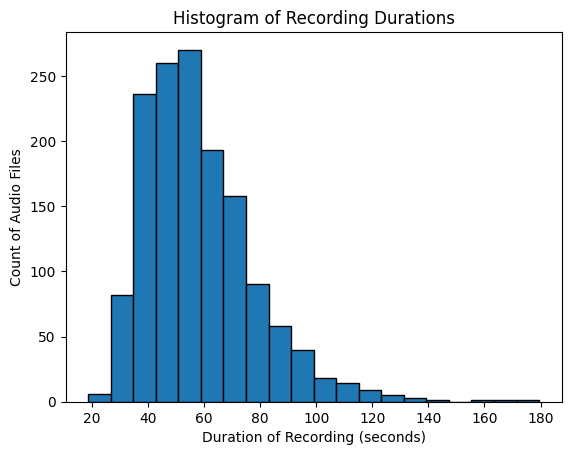

In [ ]:
durations=recording_time(path_agent)[1]
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Duration of Recording (seconds)')
plt.ylabel('Count of Audio Files')
plt.title('Histogram of Recording Durations')
plt.show()

## Transcript Analysis

**Transcripts:** The transcript json files are lists of segments where each segment is a json object with the following schema:

```json
{
    "channel_index": 2,
    "dialog_acts": [
        "gridspace_greeting"
    ],
    "duration_ms": 2280,
    "emotion": {
        "neutral": 0.33766093850135803,
        "negative": 0.024230705574154854,
        "positive": 0.6381083130836487
    },
    "human_transcript": "hello this is harper valley national bank",
    "index": 1,
    "offset_ms": 5990,
    "speaker_role": "agent",
    "start_ms": 3990,
    "start_timestamp_ms": 1591056064136,
    "transcript": "hello this is harper valley national bank",
    "word_durations_ms": [
        330,
        150,
        120,
        330,
        270,
        420,
        330
    ],
    "word_offsets_ms": [
        0,
        660,
        810,
        930,
        1260,
        1530,
        1950
    ]
}
```
The fields we will closely analyze for inference are:

- **"human_transcript":** Corrected version of the machine genereated "transcript".

- **"emotion":** Softmax output of Gridspace's Emotion model, determining whether the emotional valence of the segment was positive, negative, or neutral.

- **"dialog_acts":**. List of tags assigned to each utterance corresponding to types of conversational move represented in the utterance. There are 16 total dialog actions, and more than one can be present in an utterance. The 16 possible actions are: “yes” response, greeting, response, data confirmation, procedure explanation, data question, closing, data communication, “bear with me” response, acknowledgement, data response, filler disfluency, thanks, open question, problem description, and other.



##### <ins>**Task 1.2**</ins>**: Transcript Statistics (3 points)**

Load all transcript json files using `json.load()` and fill out the function `transcript_statistics` to get the following statistics:
- Total number of utterances
- Mean number of agent utterances per conversation
- Mean number of caller utterances per conversation
- Total number of words: Keep in mind that "[", "]", "<", ">" aren't considered as words.
- Number of unique words

You can get the text of the audio file by looking at the **"human_transcript"** field for each transcript. You can use `word_tokenize` function from `nltk.tokenize`.  

In [ ]:
import re

In [ ]:
from collections import Counter

In [ ]:
def transcript_statistics(
    path_transcript: str) -> Tuple[int, float, float, int, int]:
  """Get transcript statistics.

  Args:
    path_transcript: Path to transcript directory.

  Returns:
    Total number of utterances, Mean number of agent utterances per conversation,
    Mean number of caller utterances per conversation, total number of words,
    Number of unique words
  """
  #############################
  #### YOUR CODE GOES HERE ####





# Load transcript JSON files
  transcript_json_files = []
  path_dir= '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/transcript'
  for item in os.listdir(path_dir):
        item_path = os.path.join(path_dir, item)
        with open(item_path, "r") as file:
          transcript_json_files.append(json.load(file))
  total_utterances = len(transcript_json_files)

  total_agent_utterances=0
  for transcript_file in transcript_json_files:
    agent_utterances= sum(1 for utterance in transcript_file if utterance["speaker_role"]=="agent")
    total_agent_utterances+=agent_utterances
    mean_agent= total_agent_utterances/total_utterances

  total_caller_utterances=0
  for transcript_file in transcript_json_files:
    caller_utterances= sum(1 for utterance in transcript_file if utterance["speaker_role"]=="caller")
    total_caller_utterances+=caller_utterances
    mean_caller= total_caller_utterances/total_utterances

  total_words=0
  for transcript_file in transcript_json_files:
      for utterance in transcript_file:
        human_transcript= utterance.get("human_transcript","")
        words = nltk.word_tokenize(human_transcript)
        words = [word for word in words if not re.match(r'[\[\]<>\']', word)]
        total_words+=len(words)
  unique_words = Counter(words)
  unique= len(unique_words)


  return total_utterances, mean_agent, mean_caller, total_words, unique_words



  #############################

In [ ]:
transcript_statistics(transcript_path)

(1446,
 9.195712309820193,
 8.59820193637621,
 145286,
 Counter({'okay': 1, 'bye': 2}))

##### <ins>**Task 1.3**</ins>**: Distribution of Utterances (3 points)**

Plot the distribution of number of utterances per conversation and tell us the average number of utterances per conversation. (`X`: Number of utterances in a transcript, `Y`: Number of transcipts with `x` number of utterances)

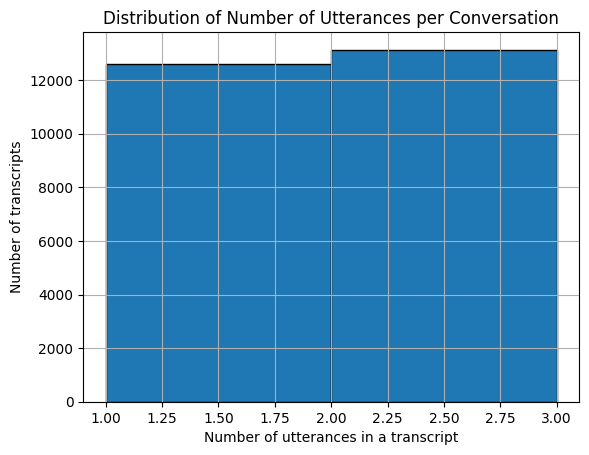

1.510532452390206

In [ ]:
num_utterances = []
#############################
#### YOUR CODE GOES HERE ####
utterances_per_conversation = []
transcript_json_files = []
path_dir= '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/transcript'
for item in os.listdir(path_dir):
        item_path = os.path.join(path_dir, item)
        with open(item_path, "r") as file:
          transcript_json_files.append(json.load(file))

for transcript_file in transcript_json_files:
  for utterance in transcript_file:
    # Get the number of utterances in the transcript
    num_utterances = len(utterance.get("dialog_acts"))

    # Append the number of utterances to the list
    utterances_per_conversation.append(num_utterances)

# Plot the distribution of the number of utterances per conversation
plt.hist(utterances_per_conversation, bins=range(1, max(utterances_per_conversation) + 2), edgecolor='black')
plt.xlabel('Number of utterances in a transcript')
plt.ylabel('Number of transcripts')
plt.title('Distribution of Number of Utterances per Conversation')
plt.grid(True)
plt.show()
#############################
avg_utt_per_convo = sum(utterances_per_conversation)/len(utterances_per_conversation)
avg_utt_per_convo

##### <ins>**Task 1.4**</ins>**: Distribution of Tasks (2 points)**

Plot histogram of the distribution of tasks. The metadata files describe the call center scenario for each converstaion. We will look at **tasks** field for further inference.

**tasks:** field indicates the customer’s goal/intent in the conversation. There are 8 tasks: _order checks, check balance, replace card, reset password, get branch hours, pay bill, schedule appointment, and transfer money_. (`X`: Eight tasks, `Y`: Number of conversations)

In [ ]:
task_names = ['order checks', 'check balance', 'replace card', 'reset password', 'get branch hours', 'pay bill', 'schedule appointment', 'transfer money']

#############################
#### YOUR CODE GOES HERE ####
metadata_json_files = []
path_dir= '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/metadata'
for item in os.listdir(path_dir):
        item_path = os.path.join(path_dir, item)
        with open(item_path, "r") as file:
          metadata_json_files.append(json.load(file))
tasks_list=[]
for metadata_file in metadata_json_files:

        tasks= metadata_file.get("tasks","")
        for task in tasks:
          task_type = task.get("task_type")
          tasks_list.append(task_type)
tasks_count= Counter(tasks_list)

pass
#############################

In [ ]:
tasks_list

['get branch hours',
 'pay bill',
 'schedule appointment',
 'check balance',
 'get branch hours',
 'order checks',
 'pay bill',
 'get branch hours',
 'replace card',
 'schedule appointment',
 'schedule appointment',
 'transfer money',
 'get branch hours',
 'get branch hours',
 'reset password',
 'check balance',
 'pay bill',
 'reset password',
 'pay bill',
 'order checks',
 'order checks',
 'check balance',
 'schedule appointment',
 'reset password',
 'reset password',
 'pay bill',
 'replace card',
 'transfer money',
 'check balance',
 'check balance',
 'check balance',
 'check balance',
 'check balance',
 'transfer money',
 'check balance',
 'check balance',
 'order checks',
 'order checks',
 'replace card',
 'order checks',
 'schedule appointment',
 'reset password',
 'check balance',
 'pay bill',
 'reset password',
 'check balance',
 'pay bill',
 'pay bill',
 'order checks',
 'replace card',
 'get branch hours',
 'check balance',
 'schedule appointment',
 'check balance',
 'schedule

In [ ]:
tasks_count

Counter({'get branch hours': 190,
         'pay bill': 180,
         'schedule appointment': 178,
         'check balance': 203,
         'order checks': 179,
         'replace card': 187,
         'transfer money': 170,
         'reset password': 159})

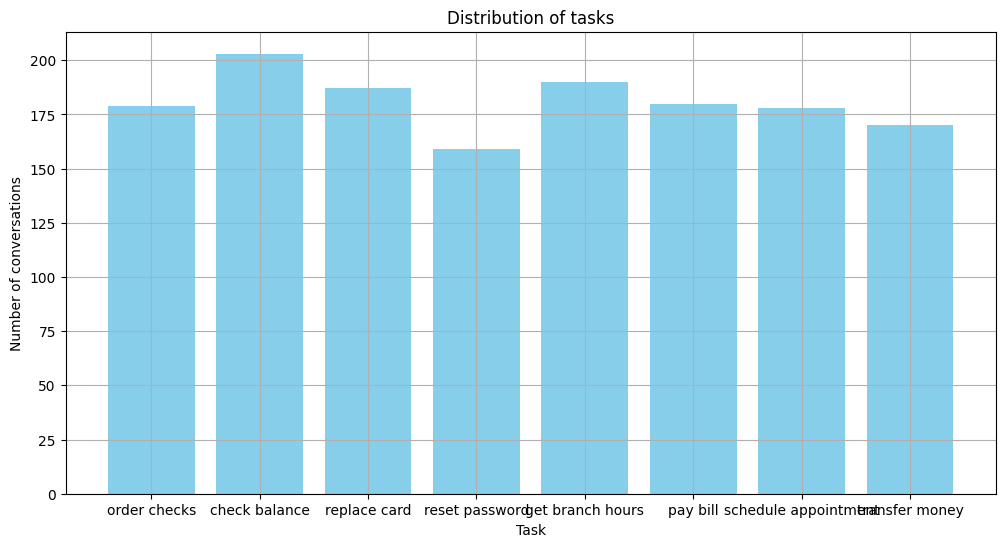

In [ ]:
task_categories = [
    "order checks", "check balance", "replace card", "reset password",
    "get branch hours", "pay bill", "schedule appointment", "transfer money"
]

# Extract the counts for each category
counts = [tasks_count[task] for task in task_categories]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(task_categories, counts, color='skyblue')
plt.xlabel('Task')
plt.ylabel('Number of conversations')
plt.title('Distribution of tasks')
plt.grid(True)
plt.show()

In [ ]:
tasks_list

['get branch hours',
 'pay bill',
 'schedule appointment',
 'check balance',
 'get branch hours',
 'order checks',
 'pay bill',
 'get branch hours',
 'replace card',
 'schedule appointment',
 'schedule appointment',
 'transfer money',
 'get branch hours',
 'get branch hours',
 'reset password',
 'check balance',
 'pay bill',
 'reset password',
 'pay bill',
 'order checks',
 'order checks',
 'check balance',
 'schedule appointment',
 'reset password',
 'reset password',
 'pay bill',
 'replace card',
 'transfer money',
 'check balance',
 'check balance',
 'check balance',
 'check balance',
 'check balance',
 'transfer money',
 'check balance',
 'check balance',
 'order checks',
 'order checks',
 'replace card',
 'order checks',
 'schedule appointment',
 'reset password',
 'check balance',
 'pay bill',
 'reset password',
 'check balance',
 'pay bill',
 'pay bill',
 'order checks',
 'replace card',
 'get branch hours',
 'check balance',
 'schedule appointment',
 'check balance',
 'schedule

In [ ]:
import itertools


##### <ins>**Task 1.5**</ins>**: Distribution of Dialog Actions (2 points)**

Plot histogram the distribution of dialog actions for utterances. Use **"dialog_acts"** field from each transcript json files. What can you infer from this plot? Please remove "gridspace_" from the labels. (e.g. "greeting" instead of "gridspace_greeting")

(`X`: Dialogue action classes, `Y`: Number of utterances)

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
transcript_json_files = []
path_dir= '/content/drive/MyDrive/cs224s_spring2022/data/harpervalleybank/transcript'
for item in os.listdir(path_dir):
        item_path = os.path.join(path_dir, item)
        with open(item_path, "r") as file:
          transcript_json_files.append(json.load(file))
dialog_list=[]
for transcript_file in transcript_json_files:
  for utterance in transcript_file:


        dialogs= utterance.get("dialog_acts","")

        dialog_list.append(dialogs)
all_dialogs = list(itertools.chain.from_iterable(dialog_list))
task_counts = Counter(all_dialogs)


pass

#############################

In [ ]:
dialog_counts=task_counts
dialog_counts

In [ ]:
new_dialog_counts = Counter({key.replace('gridspace_', ''): value for key, value in dialog_counts.items()})
new_dialog_counts

NameError: name 'dialog_counts' is not defined

In [ ]:
dialog_categories = ['greeting',
         'open_question',
         'filler_disfluency',
         'problem_description',
         'data_question',
         'other',
         'response',
         'acknowledgement',
         'closing',
         'thanks',
         'data_response',
         'data_communication',
         'confirm_data',
         'yes_response',
         'procedure_explanation',
         'bear_with_me']

In [ ]:
counts = [new_dialog_counts[dialog] for dialog in dialog_categories]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(dialog_categories, counts, color='skyblue')
plt.xlabel('Dialog_acts')
plt.ylabel('Number of utterances')
plt.title('Distribution of dialogs')
plt.grid(True)
plt.show()

##### <ins>**Task 1.6**</ins>**: Distribution of Emotions (2 points)**

Plot boxplots that show distribution of probabilities for each emotion category across utterances. Use **"emotion"** field from each transcript json files. What can you infer from this plot? (`X`: Emotion Classes, `Y`: Probability)



In [ ]:
#############################
#### YOUR CODE GOES HERE ####
neutral_probs = []
negative_probs = []
positive_probs = []

for utterance in transcript_file:
    emotion = utterance.get("emotion","")
    neutral_probs.append(emotion["neutral"])
    negative_probs.append(emotion["negative"])
    positive_probs.append(emotion["positive"])

# Plot boxplots
data = [neutral_probs, negative_probs, positive_probs]
labels = ['Neutral', 'Negative', 'Positive']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.ylabel('Probability')
plt.title('Distribution of Emotion Probabilities Across Utterances')
plt.show()
pass
#############################

The central box represents the interquartile range (IQR) where the middle 50% of the data points lie. The bottom and top of the box are the first quartile (Q1) and third quartile (Q3), respectively.
Median Line: The horizontal line inside the box represents the median (second quartile, Q2) of the data.
Whiskers: The lines extending from the box (whiskers) show the range of the data, excluding outliers. They typically extend to 1.5 times the IQR above Q3 and below Q1.
Outliers: Data points outside the whiskers are considered outliers and are sometimes plotted as individual points.

The "Neutral" emotion has the highest median probability,
suggesting that most utterances are perceived as neutral.

The "Negative" emotion has the lowest median and a relatively narrow IQR, indicating that utterances are less frequently perceived as negative, and when they are, their probabilities are not very high.

The "Positive" emotion has a wide range of probabilities, showing more variability in how often and to what extent utterances are perceived as positive.

# Part 2: Implementing CTC Loss

We introduce the Connectionist Temporal Classification (CTC) objective, which is a popular objective used to train neural networks to do speech recognition. Critically, it does not require you to know the alignments between inputs and outputs.

#### **Summary of CTC**

We highlight some of the main features of the CTC objective.

- Given a sequence of inputs `x_1, x_2, .., x_T`, an ASR model will map each of these to a probability of an alphabet of C tokens: `p_1, p_2, ..., p_T`. For example, if we are decoding to three possible characters, the probabilities for timestep `t` could look like `p_t = [0.3, 0.2, 0.5]`.

- We also have a sequence of symbol targets `y_1, y_2, ..., y_S` (note `S <= T`). Each `y_s` is a number from `0` to `C-1` (e.g. one of the characters).

- The main strategy is to decode each `x_t` to a predicted character `y'_t`. For example, `x_1, x_2, ..., x_6 -> c c a a a t`. This mapping is called an **alignment**. Then we can collapse repetitions to get `c a t` as the predicted output sequence. This simple strategy has some problems: how do you handle silences or repeated characters?

- CTC adds a special `blank` token. We'll call this `eps`. Now consider this example, `x_1, x_2, ..., x_12 -> h h e eps eps l l l eps l l o`. Now we can collapse everything in between each `eps` to get `h e eps l eps l o`. Removing blank tokens, we get the prediction `hello`.

- For an output sequence, there are many "valid" alignments. For example, given an input sequence `x_1, ..., x_6` and an output sequence `c a t`, valid alignments include `eps c c eps a t`, `c c a a t t`, or `c a eps eps eps t`. Example of invalid alignments include `c eps c eps a t`, `c c a a t` (too short if the input sequence has 6 tokens), and `c eps eps eps t t`.

- Let `A` represent all valid alignments of an output sequence to an input sequence. A simplified pseudocode for the CTC objective might look like:

```
all_log_prob = 0

for each (a_1, a_2, ..., a_S) in A:

    log_prob = 0

    for t in 1 to T:
        # The alignment a_s has a specific output character for input position t
        log_prob_t = log p(a_(s,t) | x_1, ..., x_T)
        # compute the joint probability by multiplying independent time steps
        # Adding in log space to avoid underflow
        log_prob += log_prob_t

    all_log_prob += log_prob
```
That is, the CTC loss computes the probability of all possible alignments. Please note that the pseudocode above is for intuition. In practice, it is often too slow to enumerate over `A` explicitly.

As an example, for an output sequence of length 50 (without any repeated characters) and an input sequence of length 100, the number of unique alignments is almost 10^40.

#### **Dynamic Programming in CTC**

In class, we introduced the "forward algorithm" to tractably compute likelihoods for HMMs. We can do something similar to score alignments more efficiently than manually enumerating over the full set.

In other words, we can do dynamic programming. Since many alignments share partial sub-sequences, we can  store the `log_prob` for all sub-sequences we have seen so far. This allows us to reuse computation when computing the likelihood for a new sequence.

The logic is as follows:

Recall `X` is the input sequence of maximum length `T` and `Y` is the output sequence of maximum length `S`. Build a new sequence `Z` that adds a blank token between every character.

```
Y = [y_1, y_2, ..., y_S]
Z = [eps, y_1, eps, y_2, ..., eps, y_S, eps]
  = [z_1, z_2, z_3, z_4, ..., z_2S-1, z_2S, z_2S+1]
```
Note that the length of `Z` is now `2S+1`.

**Step 1: Make a Cache.**

Instantiate a matrix of size `T x (2S+1)`. Call this matrix `C`. The index `C[t][s]` represents a probability score for the subsequence `z_1, ..., z_s` after observing `x_1, ..., x_t`. That is, `C[t][s] = p(y_1, ..., y_s/2 | x_1, ..., x_t)`.

**Step 2: Make an Update Rule.**

The goal of dynamic programming is to reuse `C[t-1]` in computing `C[t]`. To do that, we need to define an update rule. There are two cases depending on what  the token `z_s` is.

- <ins>Case 1</ins>: `z_s` is a blank token OR `z_s = z_s-2`. This is the standard forward algorithm update. We build `p(z_1, ..., z_s|x_1, ..., x_t)` using two parts: `p(z_1, ..., z_s|x_1, ..., x_t-1)` and `p(z_1, ..., z_s-1|x_1, ..., x_t-1)`. Assuming an increasing order of `t` and `s`, these two parts will already have been computed. (If `s = 0` you can ignore the `C[t-1][s-1]` term. If `t = 0`, set `C[t][s] = p(z_s | x_1, ..., x_t)`.)
```
C[t][s] = (C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```
In other words, `C[t-1][s-1]` and `C[t-1][s]` are known. The prediction for `p(z_s | x_1, ..., x_t)` is known (e.g. `log_probs`).

- <ins>Case 2</ins>: `z_s` is not a blank token AND `z_s != z_s-2`. The tricky part is to notice that `z_s-1` is a blank token. Since our Markov assumption says `y_t` should depend on `y_t-1`, which means `z_s` should depend on both `z_s-1` and `z_s-2` (since we artificially added `z_s-1`). Similarly, ignore terms that do not exist.
```
C[t][s] = (C[t-1][s-2] + C[t-1][s-1] + C[t-1][s]) * p(z_s | x_1, ..., x_t)
```

Now, we still need two for loops to loop over `1 ... T` and `1 ... S` but this is usually much cheaper than looping over alignments.

```
C = init_cache(T, S)
for t in 1 to T:
  for s in 1 to 2S+1:
    C = do_update(t, s, C)

p_y_given_x = C[-1][-1] + C[-1][-2]  # sum the probability of the last epsilon and last non-epsilon tokens
```

For more information, refer to this [blog](https://distill.pub/2017/ctc/) or the original [paper](https://www.cs.toronto.edu/~graves/icml_2006.pdf) by Alex Graves.



Please write a function in PyTorch that given a minibatch of model predicted probabilities and a minibatch of output sequences, computes the CTC objective.

**Note:** You cannot use the built-in `F.ctc_loss` in PyTorch. We will use this fast library for experiments in HW4.



In [ ]:
def ctc_loss(
    log_probs: torch.FloatTensor, targets: torch.LongTensor,
    input_lengths: torch.LongTensor, target_lengths: torch.LongTensor,
    blank: int = 0) -> torch.Tensor:
  """Connectionist Temporal Classification implementation.

  Args:
    log_probs: The log-beliefs returned by an ASR model.
      This is `log p(a_t | x_1, ..., x_T)`.
      (Shape: T x batch_size x C, where T is a maximum input sequence length and
      C is the alphabet size (including blank))

    targets: Sequence of contiguous output labels (no blanks).
      This is `y_1, ..., y_S`.
      (Shape: batch_size x S, where S is a maximum output sequence length)

    input_lengths: Lengths of each example in minibatch (<= T).
      (Shape: batch_size)

    target_lengths: Lengths of each target in minibatch (<= S).
      (Shape: batch_size)

    blank: The "epsilon" token that is used to represent silence.
      (integer <= C, default 0)

  Returns:
    CTC loss averaged over minibatch.
  """
  #############################
  #### YOUR CODE GOES HERE ####
  T,N,C = log_probs.shape
  max_target_len= targets.size(1)
  extended_targets=torch.full((N,2*max_target_len+1),blank,dtype=torch.long, device=targets.device)
  for i in range(N):
    #Inserting characters from target sequence in between the blanks
    extended_targets[i, 1:2*target_lengths[i]:2] = targets[i, :target_lengths[i]]
    log_alpha = torch.full((N, T + 1, 2 * max_target_len + 1), float('-inf'), device=log_probs.device)
    log_alpha[:, 0, 0] = 0

  for t in range(T+1):
      log_prob_t = log_probs[t - 1]
      for s in range(2*max_target_len+1):
        if s<log_alpha.shape[2]:
          log_alpha[:, t, s] = log_alpha[:, t - 1, s] + log_prob_t[:, extended_targets[:, s]]
        if s > 0:
          log_alpha[:, t, s] = torch.logaddexp(log_alpha[:, t, s]+ log_alpha[:, t - 1, s-1] + log_prob_t[:, extended_targets[:, s]])
        if s > 1 and extended_targets[:, s] != extended_targets[:, s - 2]:
                log_alpha[:, t, s] = torch.logaddexp(log_alpha[:, t, s], log_alpha[:, t - 1, s - 2] + log_prob_t[:, extended_targets[:, s]])
    #In the context of CTC, we are considering all possible alignments of the target sequence with the input sequence. Specifically:
    #Final State: The probability of the sequence ending exactly at the final target character.
    #Second-to-Last State: The probability of the sequence ending at the second-to-last target character.
    #This accounts for alignments where the final time step does not align with the last target character but rather with the preceding character (often necessary due to the presence of blank tokens).
    #By using torch.logaddexp, we are effectively summing the probabilities of these two scenarios in log space, which ensures numerical stability.

  loss = torch.tensor(0.0, device=log_probs.device)
  for n in range(N):
      l= log_alpha[n, input_lengths[n], target_lengths[n]]
      if target_lengths[n] > 0:
          l= torch.logaddexp(l, log_alpha[n, input_lengths[n], target_lengths[n]-1])
      loss -= l
  return loss/N

  pass
  #############################


In [ ]:
import torch
import torch.nn.functional as F

log_probs = torch.randn(50, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 50, dtype=torch.long)
target_lengths = torch.randint(10,30,(16,), dtype=torch.long)

est = ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0)
soln = torch.mean(F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=0, reduction='none'))

print(est.detach().numpy(), soln.detach().numpy())

In [ ]:
import torch
import torch.nn.functional as F
import random

def get_test_minibatches() -> list:
  """Get minibatches to test implementation
  Returns:
    lists of log_probs, targets, input_lengths, target_lengths
  """
  torch.manual_seed(224)
  np.random.seed(224)
  random.seed(224)

  T = np.array([])
  C = np.array([])
  N = np.array([])
  S = 40  # Target sequence length of longest target in batch (padding length)
  for i in range(10):
    T = np.append(T, random.randint(i+50, i+80))
    C = np.append(C, random.randint(int(0.4* T[i]), int(0.8*T[i])))
    N = np.append(N, random.randint(int(0.7 *C[i]), int(0.9*C[i])))

  log_probs = []
  input_lengths = []
  target_lengths = [] # 10 x N[i]
  targets = []
  for i in range(10):
    log_probs.append(torch.randn(int(T[i]), int(N[i]), int(C[i])).log_softmax(2).detach().requires_grad_())
    input_lengths.append(torch.full((int(N[i]),), fill_value = int(T[i]), dtype=torch.long))
    target_lengths.append(torch.randint(low = 1,high = S, size = (int(N[i]),), dtype=torch.long))
    targets.append(torch.randint(low = 1, high = int(C[i]), size = (int(N[i]), S), dtype=torch.long))

  return log_probs, targets, input_lengths, target_lengths

In [ ]:
log_probs, targets, input_lengths, target_lengths = get_test_minibatches()

This is the end of Part 1 & 2. Great work!